In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvzf aclImdb_v1.tar.gz

In [2]:
!pip install transformers
!pip install sentencepiece
!!pip install gpustat

     |████████████████████████████████| 2.2MB 18.8MB/s 
     |████████████████████████████████| 3.3MB 53.2MB/s 
     |████████████████████████████████| 870kB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=26506795d440ba2ed305b83ba85dbe826d517ea42bfb81650f858b15c0b88fd9
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 18.4MB/s 


['Collecting gpustat',
 '\x1b[?25l  Downloading https://files.pythonhosted.org/packages/b4/69/d8c849715171aeabd61af7da080fdc60948b5a396d2422f1f4672e43d008/gpustat-0.6.0.tar.gz (78kB)',
 '',
 '\x1b[K     |████▏                           | 10kB 17.4MB/s eta 0:00:01',
 '\x1b[K     |████████▍                       | 20kB 24.4MB/s eta 0:00:01',
 '\x1b[K     |████████████▋                   | 30kB 22.9MB/s eta 0:00:01',
 '\x1b[K     |████████████████▊               | 40kB 25.8MB/s eta 0:00:01',
 '\x1b[K     |█████████████████████           | 51kB 20.6MB/s eta 0:00:01',
 '\x1b[K     |█████████████████████████▏      | 61kB 19.6MB/s eta 0:00:01',
 '\x1b[K     |█████████████████████████████▍  | 71kB 17.7MB/s eta 0:00:01',
 '\x1b[K     |████████████████████████████████| 81kB 7.9MB/s ',
 '\x1b[?25hRequirement already satisfied: six>=1.7 in /usr/local/lib/python3.7/dist-packages (from gpustat) (1.15.0)',
 'Requirement already satisfied: nvidia-ml-py3>=7.352.0 in /usr/local/lib/python3.7/dist-packag

In [3]:
import glob
import numpy as np
import random
import string
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pylab as plt

#baseline libs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import transformers
import warnings
from transformers import BertModel
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from IPython.display import clear_output
from keras.utils import Progbar


torch.manual_seed(42)
np.random.seed(42)


warnings.filterwarnings('ignore')

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

TOKENIZER = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
DEVICE = torch.device(dev)  
FROZEN_BERT = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


### Считаем данные и подготовим для работы

In [4]:
def read_reviews(reviews_glob_path, reviews_type):
  review_text, review_tone = [], []
  for f in tqdm_notebook(glob.glob(reviews_glob_path)):
    review = open(f, 'r').read()
    review_text.append(review)
    review_tone.append(reviews_type)
  print(f'Total samples of {reviews_type} = {len(review_text)}')
  return review_text, review_tone

pos_train_review_text, pos_train_review_tone = read_reviews('/content/aclImdb/train/pos/*.txt', 'positive')
neg_train_review_text, neg_train_review_tone = read_reviews('/content/aclImdb/train/neg/*.txt', 'negative')

pos_test_review_text, pos_test_review_tone = read_reviews('/content/aclImdb/test/pos/*.txt', 'positive')
neg_test_review_text, neg_test_review_tone = read_reviews('/content/aclImdb/test/neg/*.txt', 'negative')

train_text, train_target = pos_train_review_text+neg_train_review_text, pos_train_review_tone+neg_train_review_tone
test_text, test_target = pos_test_review_text+neg_test_review_text, pos_test_review_tone+neg_test_review_tone

train_df = pd.DataFrame({"text": train_text, "target": train_target})
test_df = pd.DataFrame({"text": test_text, "target": test_target})
print(f'Train shape - {train_df.shape[0]}, test shape - {test_df.shape[0]}')
full_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True).sample(frac=1,random_state=42)
print("Full df shape: ", full_df.shape[0])
full_df.head()


Total samples of positive = 12500



Total samples of negative = 12500



Total samples of positive = 12500



Total samples of negative = 12500
Train shape - 25000, test shape - 25000
Full df shape:  50000


,text,target
33553,"This movie was an excellent acted, excellent d...",positive
9427,I was living Rawlins when this movie was made ...,positive
199,"Henry Thomas was ""great"". His character held m...",positive
12447,It's so rare to find a literary work adequatel...,positive
39489,There needs to be a 0/10 option for bilge like...,negative


In [5]:
#preprocess text
punctuation_set = set(string.punctuation + '«»—')

class_dict = {"positive":1, "negative":0}

def clean_punctuation(input_text):
    space = " "
    # replace punctuation with spaces
    cleaned_string = "".join([c if c not in punctuation_set else space for c in input_text])
    # remove duplicate whitespaces
    cleaned_string = space.join(cleaned_string.split())
    return cleaned_string


def clean_punctuation_lower(input_text):
    cleaned_string = clean_punctuation(input_text).lower()
    return cleaned_string

full_df['text'] = full_df['text'].apply(lambda x: clean_punctuation_lower(x))
full_df['target'] = full_df['target'].apply(lambda x: class_dict[x])
full_df.head()

,text,target
33553,this movie was an excellent acted excellent di...,1
9427,i was living rawlins when this movie was made ...,1
199,henry thomas was great his character held my a...,1
12447,it s so rare to find a literary work adequatel...,1
39489,there needs to be a 0 10 option for bilge like...,0


In [6]:
### Train test split
train_data, finetune_data, test_data = full_df[:2000], full_df[2000:4000], full_df[4000:5000]
print('Finetune data: ', finetune_data.shape)
print('Train shape: ', train_data.shape)
print('Test data: ', test_data.shape)

Finetune data:  (2000, 2)
Train shape:  (2000, 2)
Test data:  (1000, 2)


In [7]:
#class balance
print('Train distib: ')
print(train_data['target'].value_counts())
print('Finetune distib: ')
print(finetune_data['target'].value_counts())
print('Test distib: ')
print(test_data['target'].value_counts())

Train distib: 
1    1018
0     982
Name: target, dtype: int64
Finetune distib: 
1    1008
0     992
Name: target, dtype: int64
Test distib: 
0    530
1    470
Name: target, dtype: int64


### Baseline


In [8]:
# Simple TF-IDF + SVM approach = knowledge of important words + good separability in sparse space
baseline_model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), 
                               SGDClassifier()).fit(train_data['text'], train_data['target'])
baseline_predicted = baseline_model.predict(test_data['text'])
print(classification_report(test_data['target'], baseline_predicted))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       530
           1       0.78      0.90      0.83       470

    accuracy                           0.83      1000
   macro avg       0.84      0.84      0.83      1000
weighted avg       0.84      0.83      0.83      1000



### BERT preprocessing and data loader preparation

In [ ]:
https://huggingface.co/transformers/model_doc/bert.html

In [8]:
#tokenizer example
string_example = 'i have a funny story about dinosours'
print(TOKENIZER.tokenize(string_example))
print(TOKENIZER.encode(string_example))

['i', 'have', 'a', 'funny', 'story', 'about', 'dino', '##so', '##urs']
[101, 1045, 2031, 1037, 6057, 2466, 2055, 22412, 6499, 9236, 102]


In [9]:
def tokenize_samples(text_samples):
  tokenized_list = list(map(lambda x: TOKENIZER.encode(x, add_special_tokens=True), text_samples))
  return tokenized_list

def pad_samples(tokenized_list):
  BERT_MAX_LEN = 512
  result_list = []

  for sample in tokenized_list:
    if len(sample) < BERT_MAX_LEN:
      padded_sample = sample + [0]*(BERT_MAX_LEN-len(sample))
    else:
      padded_sample = sample[:BERT_MAX_LEN]
    result_list.append(padded_sample)

  padded_list = np.array(result_list)
  return padded_list

def mask_padded_list(padded_list):
  attention_mask = np.where(padded_list != 0, 1, 0)
  return attention_mask

def prepare_data(text_samples):
  tokenized_list = tokenize_samples(text_samples)
  padded_samples = pad_samples(tokenized_list)
  attention_mask = mask_padded_list(padded_samples)
  return padded_samples, attention_mask

train_input_ids, train_attention_mask = prepare_data(train_data['text'].tolist())
print('Train: ', train_input_ids.shape, train_attention_mask.shape)

finetune_input_ids, finetune_attention_mask = prepare_data(finetune_data['text'].tolist())
print('Val: ', finetune_input_ids.shape, finetune_attention_mask.shape)

test_input_ids, test_attention_mask = prepare_data(test_data['text'].values)
print('Test: ', test_input_ids.shape, test_attention_mask.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


Train:  (2000, 512) (2000, 512)
Val:  (2000, 512) (2000, 512)
Test:  (1000, 512) (1000, 512)


In [11]:
class Dataset(TorchDataset):
    def __init__(self, samples, attention_map, targets):
        self.samples = samples
        self.attention_map = attention_map
        self.targets = targets
        self.classes_number = len(np.unique(targets))
        
    def __getitem__(self, index):
        return torch.tensor(self.samples[index], dtype=torch.int64).to(DEVICE), \
               torch.tensor(self.attention_map[index], dtype=torch.int64).to(DEVICE), \
               torch.tensor(self.targets[index], dtype=torch.float32).to(DEVICE)

    def __len__(self):
        return len(self.samples)


train_dataset = Dataset(train_input_ids, train_attention_mask, train_data['target'].tolist())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

finetune_dataset = Dataset(finetune_input_ids, finetune_attention_mask, finetune_data['target'].tolist())
finetune_loader = DataLoader(finetune_dataset, batch_size=8, shuffle=False)

test_dataset = Dataset(test_input_ids, test_attention_mask, test_data['target'].tolist())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def test():
    ids_vector, attention_vector, target = list(train_loader)[0]
    print(ids_vector.shape, attention_vector.shape, target.shape)
    print(ids_vector.dtype, attention_vector.dtype, target.dtype)


test()

torch.Size([8, 512]) torch.Size([8, 512]) torch.Size([8])
torch.int64 torch.int64 torch.float32


In [12]:
def encode_data(bert_model, data_loader):
    encoded_data, target_data = [], []
    bert_model.eval()
    with torch.no_grad():
        bar = Progbar(len(data_loader))
        for batch in data_loader:
          input_ids, attention_map, target = batch
          outputs = bert_model.forward(input_ids, attention_map)
          pooler_output = outputs['pooler_output']
          encoded_data.append(pooler_output)
          target_data.append(target)
          bar.add(1)
    encoded_data = torch.cat(encoded_data, dim=0)
    target_data =  torch.cat(target_data, dim=0)
    return encoded_data, target_data


train_bert_embeddings, train_target_data = encode_data(FROZEN_BERT, train_loader)
print('Train loader ready!')

finetune_bert_embeddings, finetune_target_data  = encode_data(FROZEN_BERT, finetune_loader)
print('Finetune loader ready!')

test_bert_embeddings, test_target_data = encode_data(FROZEN_BERT, test_loader)
print('Test loader ready!')

250/250 [==============================] - 124s 496ms/step
Train loader ready!
250/250 [==============================] - 125s 500ms/step
Finetune loader ready!
125/125 [==============================] - 62s 500ms/step
Test loader ready!


In [13]:
class BERTEmbeddingsDataset(TorchDataset):
    def __init__(self, samples, targets):
        self.samples = samples
        self.targets = targets
        
    def __getitem__(self, index):
        return self.samples[index].to(DEVICE), self.targets[index].to(DEVICE)

    def __len__(self):
        return len(self.samples)


train_dataset = BERTEmbeddingsDataset(train_bert_embeddings, train_target_data)
train_loader_emb = DataLoader(train_dataset, batch_size=8, shuffle=True)

finetune_dataset = BERTEmbeddingsDataset(finetune_bert_embeddings, finetune_target_data)
finetune_loader_emb = DataLoader(finetune_dataset, batch_size=8, shuffle=True)

test_dataset = BERTEmbeddingsDataset(test_bert_embeddings, test_target_data)
test_loader_emb = DataLoader(test_dataset, batch_size=8, shuffle=True)


def test():
    embedding,target  = list(train_loader_emb)[0]
    print(embedding.shape, target.shape)
    print(embedding.dtype, target.dtype)


test()

torch.Size([8, 768]) torch.Size([8])
torch.float32 torch.float32


### BERT Archtitecture

![bert_architecture](https://habrastorage.org/webt/ob/pa/a6/obpaa6snqryacqb9vbyaahue7zc.png)

In [13]:
FROZEN_BERT.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
FROZEN_BERT.encoder

In [ ]:
FROZEN_BERT

In [16]:
!gpustat

5b2c7d1f48fb         Fri Apr  9 16:20:49 2021  460.32.03
[0] Tesla T4         | 60'C,   0 % |  1540 / 15109 MB |


### Use BERT embeddings as base vectorizer

In [ ]:
class DenseModel(nn.Module):
  def __init__(self):
    super(DenseModel, self).__init__()
    self.fc1 = nn.Linear(768,512)
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(512, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    fc1_output = self.fc1(input)
    dropout_output = self.dropout(fc1_output)
    relu_output = self.relu(dropout_output)
    fc2_output = self.fc2(relu_output)
    proba = self.sigmoid(fc2_output)
    return proba

def test():
  embedding, target = list(train_loader_emb)[0]
  dense_model = DenseModel().to(DEVICE)
  prediction = dense_model.forward(embedding)
  for param in dense_model.named_parameters():
    print(param[0], param[1].requires_grad)
  print(prediction)
  print(target)

test()

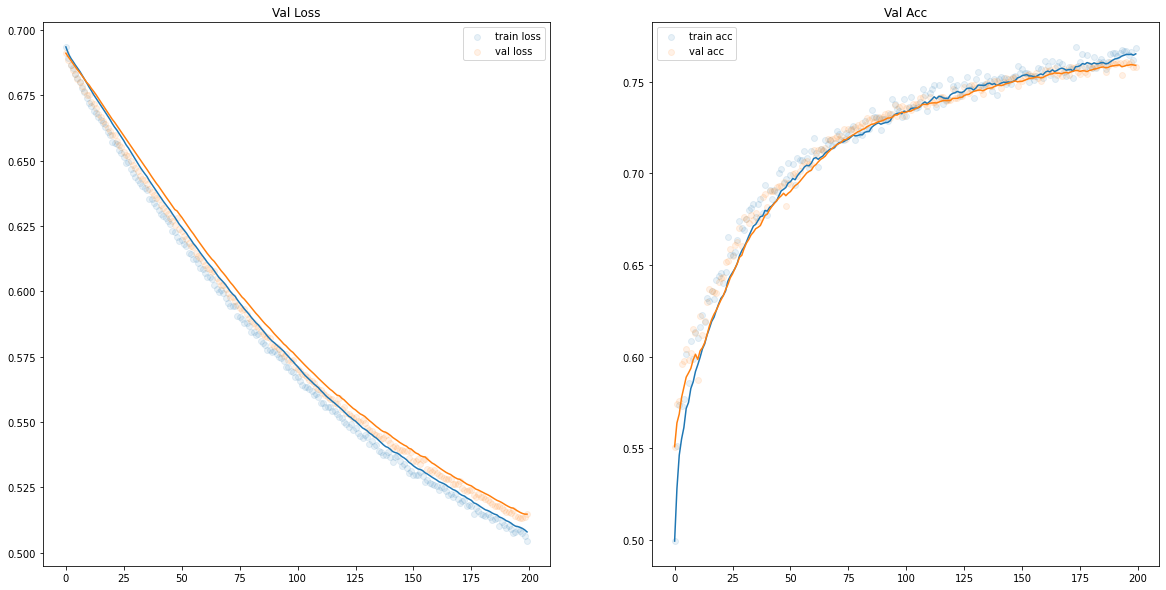

In [17]:
N_EPOCHS = 200
LEARNING_RATE=3e-6

dense_model = DenseModel().to(DEVICE)

optimizer = optim.Adam(dense_model.parameters(), lr=LEARNING_RATE)
loss_func = nn.BCELoss()

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

train_epoch_loss_array, val_epoch_loss_array = [], []
train_acc_epoch_array, val_acc_epoch_array = [], []

for epoch in range(N_EPOCHS):
  train_loss, val_loss,  = 0, 0
  train_acc, val_acc = 0, 0
  #train
  dense_model.train()
  for batch in finetune_loader_emb:
    embedding, target = batch

    dense_model.zero_grad()
    pred_proba = dense_model.forward(embedding).flatten()

    train_batch_loss = loss_func(pred_proba, target)
    train_loss += train_batch_loss.item()
    
    train_batch_loss.backward()
    optimizer.step()

    #evaluate train acc
    pred_proba_np = pred_proba.cpu().detach().numpy() 
    predicted_targets = pred_proba_np > 0.5
    true_values = target.cpu().detach().numpy() 
    true_values = true_values == 1
    train_acc += (predicted_targets == true_values).astype(float).sum()

  train_epoch_loss_array.append(train_loss / len(finetune_loader))
  train_acc_epoch_array.append(train_acc / len(finetune_dataset))

  #evaluate
  dense_model.eval()
  for batch in train_loader_emb:
    with torch.no_grad():
      embedding, target = batch

      pred_proba = dense_model.forward(embedding).flatten()
      
      val_batch_loss = loss_func(pred_proba, target)
      val_loss += val_batch_loss.item()

      #evaluate val acc
      pred_proba_np = pred_proba.cpu().detach().numpy() 
      predicted_targets = pred_proba_np > 0.5
      true_values = target.cpu().detach().numpy() 
      true_values = true_values == 1
      val_acc += (predicted_targets == true_values).astype(float).sum()      

  val_epoch_loss_array.append(val_loss / len(train_loader_emb))
  val_acc_epoch_array.append(val_acc / len(train_dataset))


  clear_output(True)
  plt.figure(figsize=[20, 10])
  #plot train loss
  plt.subplot(1, 2, 1), plt.title('Train Loss'), plt.grid()
  plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
  plt.plot(ewma(train_epoch_loss_array, span=10))
  plt.legend()
  #plot train acc
  plt.subplot(1, 2, 2), plt.title('Train Acc'), plt.grid()
  plt.scatter(np.arange(len(train_acc_epoch_array)), train_acc_epoch_array, alpha=0.1, label='train acc')
  plt.plot(ewma(train_acc_epoch_array, span=10))
  plt.legend()
  #plot val loss
  plt.subplot(1, 2, 1), plt.title('Val Loss'), plt.grid()
  plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
  plt.plot(ewma(val_epoch_loss_array, span=10))
  plt.legend()
  #plot val acc
  plt.subplot(1, 2, 2), plt.title('Val Acc'), plt.grid()
  plt.scatter(np.arange(len(val_acc_epoch_array)), val_acc_epoch_array, alpha=0.1, label='val acc')
  plt.plot(ewma(val_acc_epoch_array, span=10))
  plt.legend()
  plt.show()

In [18]:
dense_model.eval()
bert_predicted, true_y = [], []
bar=Progbar(len(test_loader_emb))
with torch.no_grad():
    for batch in test_loader_emb:
        embedding, target = batch
        logits = dense_model(embedding)
        pred_proba = logits.cpu().detach().numpy()
        bert_predicted += list(pred_proba[:, 0] > 0.5)
        true_y += list(target.cpu().detach().numpy())

        bar.add(1)

125/125 [==============================] - 0s 704us/step


In [19]:
print(classification_report(true_y, bert_predicted))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       530
         1.0       0.73      0.69      0.71       470

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



### Bert finetuning


In [20]:
class BERTClassifier(nn.Module):
    def __init__(self, layers_freeze_num, debug_info, dropout=0.1):
        super(BERTClassifier, self).__init__()

        self.bert = FROZEN_BERT
        total_layers = len(self.bert.encoder.layer)

        if 1 <= layers_freeze_num <= 11:
          layers4freeze = [*self.bert.encoder.layer[:layers_freeze_num]]
          layers2train = [*self.bert.encoder.layer[layers_freeze_num - total_layers:]]

          for layer in layers4freeze:
            for param in layer.parameters():
              param.requires_grad = False

          for layer in layers2train:
            for param in layer.parameters():
              param.requires_grad = True

          self.bert.embeddings.requires_grad_(True)
          self.bert.pooler.requires_grad_(True)
        else:

          for param in self.bert.parameters():
            param.requires_grad = False

        if debug_info:
            print('Encoder stack len: ', total_layers)
            print('Trainable layers: ')
            for i in list(self.bert.named_parameters()):
              if i[1].requires_grad:
                print(i[0])
            print()

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        bert_pooler_output = self.bert(tokens, attention_mask=masks, output_hidden_states=False)['pooler_output']
        dropout_output = self.dropout(bert_pooler_output)
        fc1_ouput = self.fc1(dropout_output)
        proba = self.sigmoid(fc1_ouput)
        return proba

def test():
  ids_vector, attention_vector, target = list(train_loader)[0]
  bert_finetune_model = BERTClassifier(layers_freeze_num=10, debug_info=True).to(DEVICE)
  prediction = bert_finetune_model.forward(ids_vector, attention_vector)
  print(prediction)

test()

Encoder stack len:  12
Trainable layers: 
embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.10.attention.self.query.weight
encoder.layer.10.attention.self.query.bias
encoder.layer.10.attention.self.key.weight
encoder.layer.10.attention.self.key.bias
encoder.layer.10.attention.self.value.weight
encoder.layer.10.attention.self.value.bias
encoder.layer.10.attention.output.dense.weight
encoder.layer.10.attention.output.dense.bias
encoder.layer.10.attention.output.LayerNorm.weight
encoder.layer.10.attention.output.LayerNorm.bias
encoder.layer.10.intermediate.dense.weight
encoder.layer.10.intermediate.dense.bias
encoder.layer.10.output.dense.weight
encoder.layer.10.output.dense.bias
encoder.layer.10.output.LayerNorm.weight
encoder.layer.10.output.LayerNorm.bias
encoder.layer.11.attention.self.query.weight
encoder.layer.11.attention.self.query.bias
encoder.layer.11

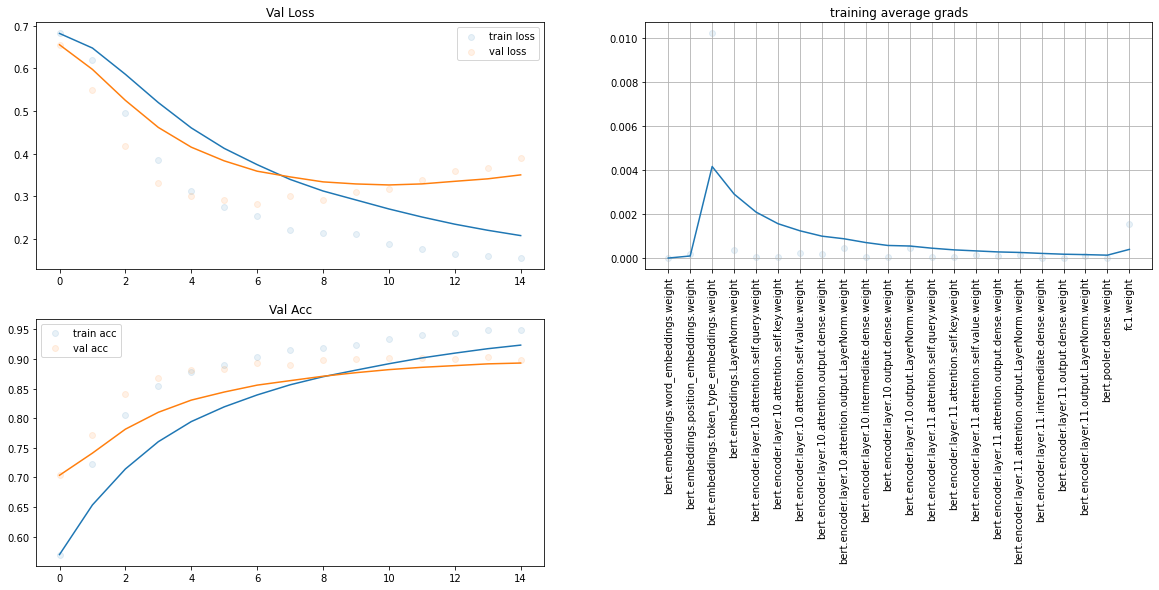

In [21]:
N_EPOCHS = 15
LEARNING_RATE=3e-6

bert_finetune_model = BERTClassifier(layers_freeze_num=10, debug_info=False).to(DEVICE)

optimizer = optim.Adam(bert_finetune_model.parameters(), lr=LEARNING_RATE)
loss_func = nn.BCELoss()

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

train_epoch_loss_array, val_epoch_loss_array = [], []
train_acc_epoch_array, val_acc_epoch_array = [], []

for epoch in range(N_EPOCHS):
  train_loss, val_loss,  = 0, 0
  train_acc, val_acc = 0, 0
  #train
  bar=Progbar(len(finetune_loader))
  bert_finetune_model.train()
  for batch in finetune_loader:
    ids_vector, attention_vector, target = batch

    bert_finetune_model.zero_grad()
    pred_proba = bert_finetune_model(ids_vector, attention_vector).flatten()
    
    train_batch_loss = loss_func(pred_proba, target)
    train_loss += train_batch_loss.item()
    
    train_batch_loss.backward()
    clip_grad_norm_(parameters=bert_finetune_model.parameters(), max_norm=1.0)
    optimizer.step()

    #evaluate train acc
    pred_proba_np = pred_proba.cpu().detach().numpy() 
    predicted_targets = pred_proba_np > 0.5
    true_values = target.cpu().detach().numpy() 
    true_values = true_values == 1
    train_acc += (predicted_targets == true_values).astype(float).sum()
    bar.add(1)

  train_epoch_loss_array.append(train_loss / len(finetune_loader))
  train_acc_epoch_array.append(train_acc / len(finetune_dataset))

  #evaluate
  bar=Progbar(len(train_loader))
  bert_finetune_model.eval()
  for batch in train_loader:
    with torch.no_grad():
      ids_vector, attention_vector, target = batch

      pred_proba = bert_finetune_model(ids_vector, attention_vector).flatten()
      
      val_batch_loss = loss_func(pred_proba, target)
      val_loss += val_batch_loss.item()

       #evaluate val acc
      pred_proba_np = pred_proba.cpu().detach().numpy() 
      predicted_targets = pred_proba_np > 0.5
      true_values = target.cpu().detach().numpy() 
      true_values = true_values == 1
      val_acc += (predicted_targets == true_values).astype(float).sum()
      bar.add(1)
      

  val_epoch_loss_array.append(val_loss / len(train_loader))
  val_acc_epoch_array.append(val_acc / len(train_dataset))


  clear_output(True)
  plt.figure(figsize=[20, 10])

  #plot train loss
  plt.subplot(2, 2, 1), plt.title('Train Loss'), plt.grid()
  plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
  plt.plot(ewma(train_epoch_loss_array, span=10))
  plt.legend()

  #plot bert gradient change
  layers_list = []
  average_grads_list = []
  for layer_name, params in bert_finetune_model.named_parameters():
    if (params.requires_grad) and ("bias" not in layer_name):
      layers_list.append(layer_name)
      mean_gradient_value = params.grad.abs().mean().item()
      # total_sample_gradient_amount += params.grad.abs().sum().item()
      average_grads_list.append(mean_gradient_value)
  plt.subplot(2, 2, 2), plt.title('training average grads'), plt.grid()
  plt.scatter(layers_list, average_grads_list, alpha=0.1)
  plt.xticks(range(0,len(average_grads_list), 1), layers_list, rotation="vertical")
  plt.plot(ewma(average_grads_list, span=10))

  #plot train acc
  plt.subplot(2, 2, 3), plt.title('Train Acc'), plt.grid()
  plt.scatter(np.arange(len(train_acc_epoch_array)), train_acc_epoch_array, alpha=0.1, label='train acc')
  plt.plot(ewma(train_acc_epoch_array, span=10))
  plt.legend()

  #plot val loss
  plt.subplot(2, 2, 1), plt.title('Val Loss'), plt.grid()
  plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
  plt.plot(ewma(val_epoch_loss_array, span=10))
  plt.legend()

  #plot val acc
  plt.subplot(2, 2, 3), plt.title('Val Acc'), plt.grid()
  plt.scatter(np.arange(len(val_acc_epoch_array)), val_acc_epoch_array, alpha=0.1, label='val acc')
  plt.plot(ewma(val_acc_epoch_array, span=10))
  plt.legend()

  plt.show()

In [32]:
#predict on test
bert_finetune_model.eval()
predicted_proba, bert_predicted, true_y = [], [], []
bar=Progbar(len(test_loader))
with torch.no_grad():
    for batch in test_loader:
        token_ids, masks, target = batch

        logits = bert_finetune_model(token_ids, masks)
        pred_proba = logits.cpu().detach().numpy()
        
        predicted_proba += list(pred_proba[:,0])
        bert_predicted += list(pred_proba[:, 0] > 0.5)
        true_y += list(target.cpu().detach().numpy())

        bar.add(1)

125/125 [==============================] - 63s 504ms/step


In [36]:
print('Average proba: ', np.array(predicted_proba).mean())

Average proba:  0.519804


In [35]:
print(classification_report(true_y, bert_predicted))

              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88       530
         1.0       0.84      0.93      0.88       470

    accuracy                           0.88      1000
   macro avg       0.88      0.89      0.88      1000
weighted avg       0.89      0.88      0.88      1000



### Сохраним нашу модель и опять загрузим - важный инструмент при работе с большими моделями

In [37]:
 from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:
import os

if not os.path.exists('gdrive/MyDrive/Teaching/finetuned_bert'):
    os.makedirs('gdrive/MyDrive/Teaching/finetuned_bert')

torch.save(bert_finetune_model.state_dict(), 'gdrive/MyDrive/Teaching/finetuned_bert/finetuned_bert_model.pth')

In [39]:
bert_loaded_model_path = 'gdrive/MyDrive/Teaching/finetuned_bert/finetuned_bert_model.pth'

bert_finetune_model = BERTClassifier(layers_freeze_num=10, debug_info=False).to(DEVICE)
bert_finetune_model.load_state_dict(torch.load(bert_loaded_model_path))
bert_finetune_model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru